In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Demo

Per priam cosa scarichiamo il dataset delle ricette e il dataset CSEL degli ingredienti

In [ ]:
import requests
import pandas as pd
from io import BytesIO
from zipfile import ZipFile

def download_and_extract_csv(zip_url):
    # Download the ZIP file
    response = requests.get(zip_url)
    response.raise_for_status()  # This will raise an error if the download failed

    # Extract the CSV file
    with ZipFile(BytesIO(response.content)) as thezip:
        # Assuming there's only one CSV file in the zip
        with thezip.open(thezip.namelist()[0]) as thefile:
            df = pd.read_csv(thefile)

    return df

def download_csv(csv_url):
    response = requests.get(csv_url)
    response.raise_for_status()

    # Qui puoi modificare 'sep' o aggiungere altri parametri se necessario
    try:
        df = pd.read_csv(BytesIO(response.content), sep=',')
    except pd.errors.ParserError:
        df = pd.read_csv(BytesIO(response.content), sep=';', error_bad_lines=False)

    return df

In [ ]:
recipes_df = download_and_extract_csv("https://gitlab.com/felix134/connected-recipe-data-set/-/raw/master/data/hummus_data/preprocessed/pp_recipes.zip")
#ingredients_df = download_csv("https://raw.githubusercontent.com/swapUniba/FoodPrintDB-Database-Completion/main/SuEatableLife%20Database/CSEL_dataset/cfp_wfp_ingredients.csv")

<ipython-input-2-6bea216b2321>:15: DtypeWarning: Columns (35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(thefile)


Creo il dizionario verificando che il nome dell'ingrediente del dataset CSEL sia contenuto nel nome dell'ingrediente del dataset delle ricette. Di conseguenza, di ognuno di questi ingredienti trovati prendo anche i valori di co2 e wfp

In [ ]:
def create_dict_ing_cfp_wfp(recipes_df, ingredients_df):
    ingredient_dict = {'name': [], 'co2': [], 'wfp': []}

    # Utilizzo della nuova funzione per ottenere tutti gli ingredienti unici
    unique_ingredients = get_all_unique_ingredients(recipes_df)

    for ing in unique_ingredients:
        for index, row in ingredients_df.iterrows():
            if row['Food commodity ITEM'] in ing.upper():
                f_co2 = str(row['final_co2']).replace(',', '.')
                f_wfp = str(row['final_wfp']).replace(',', '.')

                ingredient_dict['name'].append(ing)
                ingredient_dict['co2'].append(f_co2)
                ingredient_dict['wfp'].append(f_wfp)
                break

    return ingredient_dict


In questo metodo faccio il calcolo dell'iss(indice di sostenibilità di ogni singolo ingrediente) normalizzato. Prendo l'indice dell'ingrediente dal dizionario che mi sono creato e faccio il calcolo utilizzando la formula *foto*.

In [ ]:
import numpy as np

ingredient_dict = pd.read_csv('/content/drive/MyDrive/uni/proj_semantics/present_ingredients_df_updated.csv')
ing_dict_co2_list = ingredient_dict['co2'].to_list()
ing_dict_wfp_list = ingredient_dict['wfp'].to_list()

ing_dict_co2_list = [float(item) for item in ing_dict_co2_list]
ing_dict_wfp_list = [float(item) for item in ing_dict_wfp_list]

min_co2 = ing_dict_co2_list[np.argmin(ing_dict_co2_list)]
max_co2 = ing_dict_co2_list[np.argmax(ing_dict_co2_list)]
min_wfp = ing_dict_wfp_list[np.argmin(ing_dict_wfp_list)]
max_wfp = ing_dict_wfp_list[np.argmax(ing_dict_wfp_list)]
ingredient_names = set(ingredient_dict['name'])

In [ ]:
index = ingredient_dict['name'].to_list().index('oil')
print(ing_dict_co2_list[index])
print(ing_dict_wfp_list[index])

print(min_co2)
print(max_co2)
print(min_wfp)
print(max_wfp)

2.11
4490.0
0.19
25.23
41.0
731000.0


In [ ]:
import numpy as np

def calculate_iss(ingredient, ingredient_dict):
    a = 0.8
    b = 0.2
    try:
        index = ingredient_dict['name'].to_list().index(ingredient)

        ncfp = (ing_dict_co2_list[index] - min_co2) / (max_co2 - min_co2)
        nwfp = (ing_dict_wfp_list[index] - min_wfp) / (max_wfp - min_wfp)

        return ingredient_dict.iloc[index]['name'], a * ncfp + b * nwfp
    except:
        return None

In questo metodo calcolo il dss di ogni ricetta, quindi prendo l'indice di ogni ricetta e calcolo l'iss di ogni ingrediente di ogni ricetta, includendo nel calcolo solo gli ingredienti di cui l'iss non è nullo(dato il problema della mancanza di alcuni ingredienti nel dataset CSEL).

In [ ]:
def calculate_dss_score_recipe(recipe_index, recipes_df, ingredient_dict):
    e = 2.71
    iss_recipe = []
    known_ingredients_count = 0

    # Estrai la lista degli ingredienti per la ricetta corrente
    ingredients_list = recipes_df.iloc[recipe_index]['ingredients']
    total_ingredients_count = len(ingredients_list)

    # Conta quanti ingredienti sono conosciuti utilizzando ingredient_dict
    for ing in ingredients_list:
        if ing in ingredient_names:
            known_ingredients_count += 1

    # Calcola la percentuale di ingredienti conosciuti
    known_ingredients_percentage = (known_ingredients_count / total_ingredients_count) * 100 if total_ingredients_count > 0 else 0

    # Procedi con il calcolo dello score solo se almeno l'70% degli ingredienti è conosciuto
    if known_ingredients_percentage >= 70:
        for ing in ingredients_list:
            iss = calculate_iss(ing, ingredient_dict)
            if iss is not None:
                iss_recipe.append(iss)

        iss_recipe.sort(key=lambda x: x[1], reverse=True)
        sum_iss = sum(iss[1] * (e ** (-index)) for index, iss in enumerate(iss_recipe))

        return sum_iss
    else:
        return 0


In questo metodo, dopo aver calcolato i dss di ogni ricetta, calcolo l'indice di sotenibilità di ogni ricetta normalizzato.

In [ ]:
def calculate_ss_recipe(dss, recipe_index,max_dss,min_dss):
    return (dss[recipe_index] - min_dss) / (max_dss - min_dss)

In questo metodo, chiamo tutti i metodo relativi al calcolo della sostenibilità di ogni ricetta e ritorno il dataframe contenente le ricette ordine per sostenibilità(dalla più sostenibile alla meno

In [ ]:
def sort_recipes_by_sustainability_score(recipes_df):
    #ingredient_dict = create_dict_ing_cfp_wfp(recipes_df, ingredients_df)
    recipes_with_sustainability = []
    dss = []

    print("DSS")
    # Calcolo dello score di sostenibilità per ogni ricetta nel DataFrame
    for i in range(len(recipes_df)):
        dss.append(calculate_dss_score_recipe(i, recipes_df, ingredient_dict))
        if i % 10000 == 0 :
          print(i)

    max_dss=dss[np.argmax(dss)]
    min_dss=dss[np.argmin(dss)]
    print("Updating Recipes")
    for i in range(len(recipes_df)):
      recipes_with_sustainability.append((recipes_df.iloc[i]['title'], calculate_ss_recipe(dss, i, max_dss, min_dss)))
      if i % 10000 == 0 :
          print(i)

    # Ordinamento delle ricette in base allo score di sostenibilità
    recipes_with_sustainability.sort(key=lambda x: x[1])

    # Creazione di un DataFrame con i risultati
    df = pd.DataFrame(recipes_with_sustainability, columns=['Title', 'Sustainability Score'])
    df_filtered = df[df['Sustainability Score'] != 0]
    return df_filtered


In [ ]:
# ingredients_df = ingredients_df.dropna()
# ingredients_df['Food commodity ITEM'] = clean_ingredients_dataframe(ingredients_df)

In [ ]:
#ingredients_df.head(10)

,FOOD COMMODITY GROUP,Food commodity ITEM,Food commodity TYPOLOGY,Food commodity sub-TYPOLOGY,final_co2,final_wfp
1,AGRICULTURAL PROCESSED,ALMOND MILK,VEGETAL MILK,-,"0,54",2030
3,AGRICULTURAL PROCESSED,APPLE JUICE ( ),FRUIT JUICE (imported ingredients),-,"2,86",1140
4,AGRICULTURAL PROCESSED,AZUKI BEAN FLOUR,LEGUME FLOUR,-,"1,32",2523
5,AGRICULTURAL PROCESSED,BARLEY FLAKES,BREAKFAST CEREALS,-,"2,64",1977
6,AGRICULTURAL PROCESSED,BEANS ( F ),LEGUMES FROZEN,-,"2,26",801
7,AGRICULTURAL PROCESSED,BEANS,LEGUMES CANNED,-,"0,78","555,5"
8,AGRICULTURAL PROCESSED,BEER,BEER,-,"0,69",155
9,AGRICULTURAL PROCESSED,BEER GLASS,BEER,-,"0,96",155
10,AGRICULTURAL PROCESSED,BEER MODULAR,BEER,-,"0,53",155
11,AGRICULTURAL PROCESSED,BEER,BEER*,-,"0,69",155


In [ ]:
import ast
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Definire la lista delle stop words
stop_words = set(stopwords.words('english'))

def clean_ingredient(ingredient):
    # Rimuovere numeri, caratteri speciali e il contenuto tra parentesi tonde (compreso)
    ingredient = re.sub(r'\([^)]*\)|[0-9]+|\W+', ' ', ingredient)

    # Tokenizza la frase
    words = word_tokenize(ingredient)

    # POS tagging
    tagged_words = pos_tag(words)

    # Filtra le parole eliminando stop words, verbi, aggettivi e mantenendo solo i sostantivi
    filtered_words = [word for word, tag in tagged_words if tag.startswith('NN') and word.lower() not in stop_words]

    # Ricostruisci l'ingrediente pulito
    cleaned_ingredient = ' '.join(filtered_words)

    return cleaned_ingredient

def clean_ingredients_dataframe(recipes_df):
    for index, row in recipes_df.iterrows():
        ingredients_field = row['ingredients']
        # Verifica se il campo ingredients è NaN o vuoto
        if pd.isna(ingredients_field) or ingredients_field == '':
            continue  # Salta la riga se non ci sono ingredienti

        # Valutazione letterale del campo stringa in un dizionario Python
        try:
            ingredients_data = ast.literal_eval(ingredients_field)
        except ValueError:
            # Se non è possibile valutare letteralmente, continua con la prossima iterazione
            continue

        cleaned_ingredients = []

        for value in ingredients_data.values():
            for item in value:
                ingredient = item[0]  # Prende solo il nome dell'ingrediente, non la quantità
                cleaned_ingredient = clean_ingredient(ingredient)
                cleaned_ingredients.append(cleaned_ingredient)

        # Aggiorna la colonna ingredients del DataFrame esistente
        recipes_df.at[index, 'ingredients'] = cleaned_ingredients

    return recipes_df


def clean_recipes_dataframe(recipes_df):
    # Rimozione delle ricette senza ingredienti
    recipes_df_cleaned = recipes_df.dropna(subset=['ingredients'])
    recipes_df_cleaned = recipes_df_cleaned[recipes_df_cleaned['ingredients'] != '']

    # Rimozione dei duplicati in base al titolo
    recipes_df_cleaned = recipes_df_cleaned.drop_duplicates(subset='title', keep='first')

    # Mantenimento solo delle ricette con tag validi
    recipes_df_cleaned = recipes_df_cleaned[recipes_df_cleaned['tags'].notna() & (recipes_df_cleaned['tags'] != '')]

    return recipes_df_cleaned

recipes_df_cleaned=clean_recipes_dataframe(recipes_df)

# Utilizzo della funzione
recipes_df_cleaned = clean_ingredients_dataframe(recipes_df_cleaned)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
len(recipes_df_cleaned)

214800

In [ ]:
sort_by_sus = sort_recipes_by_sustainability_score(recipes_df_cleaned)

DSS
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
Updating Recipes
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000


In [ ]:
len(sort_by_sus)

100870

In [ ]:
sort_by_sus.head(20)

,Title,Sustainability Score
113930,Jack O Lantern 'o Fragrance,0.002409
113931,Boiled Radishes,0.002502
113932,Horseradish Applesauce,0.002590
113933,Survival Necklace,0.002623
113934,Apple Cider Reduction,0.002623
113935,Homemade Apple Pectin Stock,0.002623
113936,Easy Applesauce,0.002623
113937,Cider Baked Sausage,0.002752
113938,Easy Granita,0.003682
113939,"Rehydrated Onions, Mcdonald's Style",0.004219


In [ ]:
sort_by_sus1 = sort_by_sus.copy()

In [ ]:
def categorize_sustainability(score):
    if score <= 0.1:
        return 0
    elif 0.1 < score < 0.5:
        return 1
    else:
        return 2

sort_by_sus1['sustainability_label'] = sort_by_sus1['Sustainability Score'].apply(categorize_sustainability)

In [ ]:
sort_by_sus1 = sort_by_sus1.rename(columns={'Sustainability Score': 'sustainability_score'})
sort_by_sus1 = sort_by_sus1.rename(columns={'Title': 'title'})

In [ ]:
sort_by_sus1

,title,sustainability_score,sustainability_label
113930,Jack O Lantern 'o Fragrance,0.002409,0
113931,Boiled Radishes,0.002502,0
113932,Horseradish Applesauce,0.002590,0
113933,Survival Necklace,0.002623,0
113934,Apple Cider Reduction,0.002623,0
...,...,...,...
214795,Curried Lamb on Rice,0.951024,2
214796,Rich Lamb Curry,0.960504,2
214797,"Middle Eastern Slow-Cooked Stew With Lamb, Chi...",0.968458,2
214798,Five Meat Chili Con Carne With Beans,0.971454,2


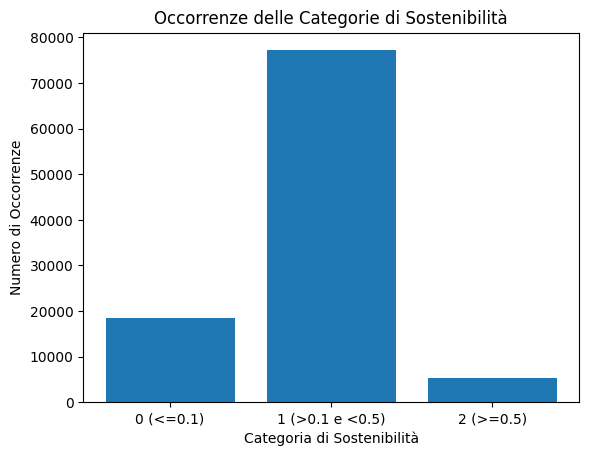

In [ ]:
import matplotlib.pyplot as plt

label_counts = sort_by_sus1['sustainability_label'].value_counts()

plt.bar(label_counts.index, label_counts.values)

plt.title('Occorrenze delle Categorie di Sostenibilità')
plt.xlabel('Categoria di Sostenibilità')
plt.ylabel('Numero di Occorrenze')
plt.xticks([0, 1, 2], ['0 (<=0.1)', '1 (>0.1 e <0.5)', '2 (>=0.5)'])

plt.show()

In [ ]:
label_counts = sort_by_sus1['sustainability_label'].value_counts()
label_counts

1    77209
0    18381
2     5280
Name: sustainability_label, dtype: int64

In [ ]:
# Unire i DataFrame sulla base di 'recipe_id', mantenendo solo le ricette in comune (inner join).
df_merged = pd.merge(sort_by_sus1, recipes_df_cleaned, on='title', how='inner')

In [ ]:
len(df_merged)

100870

In [ ]:
df_merged.iloc[0].sustainability_score

0.002409116138126371

In [ ]:
df_merged.to_csv('valid_recipes_dataset.csv', index=False)